In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import CalibrationDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
import itertools

import warnings
warnings.filterwarnings('ignore')

In [90]:
# на случай если захочется воспроизвести результаты
# тут еще не зватает зафиксировать random seed для всего и версию python
!pip list

Package                            Version   
---------------------------------- ----------
-cipy                              1.3.1     
aiohttp                            3.8.6     
aiosignal                          1.3.1     
alabaster                          0.7.12    
anaconda-client                    1.7.2     
anaconda-navigator                 1.9.7     
anaconda-project                   0.8.3     
asn1crypto                         1.0.1     
astroid                            2.3.1     
astropy                            3.2.1     
async-timeout                      4.0.3     
asynctest                          0.13.0    
atomicwrites                       1.3.0     
attrs                              24.2.0    
Babel                              2.7.0     
backcall                           0.1.0     
backports.functools-lru-cache      1.6.4     
backports.os                       0.1.1     
backports.shutil-get-terminal-size 1.0.0     
backports.tempfile                

In [2]:
df = pd.read_csv("C:/Users/maslo/курсы/karpov_start_ml/5_module/6_lesson/materials/train.csv")
df.head()

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender,Default
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,5,36.0,Male,0
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,5,29.0,Female,1
2,34822849,2016-02-18,2015-11-11,NaN,NaN,NaN,NaN,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,5,56.0,Female,0
3,46893387,2016-04-30,2016-03-22,NaN,NaN,NaN,NaN,0.0,Tavern_district_2,13,2.5,-2,5,2.5,-3,5,27.0,Female,0
4,67128275,2016-09-19,2016-07-21,NaN,NaN,NaN,NaN,0.0,Tavern_district_4,39,2.5,-3,7,2.5,-3,5,37.0,Female,0


# Анализ датасета

Рассмотрим данные в отрыве от того что они могут вообще значить

In [3]:
# типы колонок
df.dtypes

Deal_id                     int64
Deal_date                  object
First_deal_date            object
Secret_dwarf_info_1       float64
Secret_dwarf_info_2       float64
Secret_dwarf_info_3       float64
First_default_date         object
Successful_deals_count    float64
Region                     object
Tavern                      int64
Hashed_deal_detail_1      float64
Hashed_deal_detail_2        int64
Hashed_deal_detail_3        int64
Hashed_deal_detail_4      float64
Hashed_deal_detail_5        int64
Hashed_deal_detail_6        int64
Age                       float64
Gender                     object
Default                     int64
dtype: object

Имеет смысл сразу привести Deal_date, First_deal_date, First_default_date к типу даты

In [4]:
df['Deal_date'] = pd.to_datetime(df['Deal_date'], format='%Y-%m-%d')
df['First_deal_date'] = pd.to_datetime(df['First_deal_date'], format='%Y-%m-%d')
df['First_default_date'] = pd.to_datetime(df['First_default_date'], format='%Y-%m-%d')

In [5]:
# статистики
df.describe()

,Deal_id,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Default
count,3.168000e+03,535.000000,535.000000,535.000000,3154.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.0,3168.000000,3168.000000
mean,4.605727e+07,3.935514,-2.299065,5.267290,1.043754,13.350694,2.518939,-2.404356,8.462437,3.193813,-2.981692,5.0,36.411616,0.110795
std,5.370953e+07,0.888467,0.734579,0.498645,1.649416,8.851891,0.351308,2.474564,3.521127,2.048743,0.245540,0.0,10.821444,0.313928
min,5.856790e+05,2.500000,-3.000000,5.000000,0.000000,2.000000,2.500000,-3.000000,5.000000,2.500000,-3.000000,5.0,20.000000,0.000000
25%,2.761608e+07,3.500000,-3.000000,5.000000,0.000000,7.000000,2.500000,-3.000000,6.000000,2.500000,-3.000000,5.0,28.000000,0.000000
50%,4.349426e+07,3.500000,-2.000000,5.000000,0.000000,8.000000,2.500000,-3.000000,8.000000,2.500000,-3.000000,5.0,34.000000,0.000000
75%,5.778544e+07,4.500000,-2.000000,5.000000,2.000000,15.000000,2.500000,-3.000000,10.000000,2.500000,-3.000000,5.0,43.000000,0.000000
max,6.927701e+08,9.500000,2.000000,8.000000,17.000000,58.000000,17.500000,78.000000,29.000000,37.500000,4.000000,5.0,72.000000,1.000000


In [6]:
# пустые значения
df.isna().mean()

Deal_id                   0.000000
Deal_date                 0.000000
First_deal_date           0.000000
Secret_dwarf_info_1       0.831124
Secret_dwarf_info_2       0.831124
Secret_dwarf_info_3       0.831124
First_default_date        0.831124
Successful_deals_count    0.004419
Region                    0.002210
Tavern                    0.000000
Hashed_deal_detail_1      0.000000
Hashed_deal_detail_2      0.000000
Hashed_deal_detail_3      0.000000
Hashed_deal_detail_4      0.000000
Hashed_deal_detail_5      0.000000
Hashed_deal_detail_6      0.000000
Age                       0.000000
Gender                    0.000000
Default                   0.000000
dtype: float64

Видим что Secret_dwarf_info_1, Secret_dwarf_info_2, Secret_dwarf_info_3 в основном пустые \
Есть соблазн исключить их сразу из датасета \
Но видно по доле пустых значений что есть связь между заполненностью Secret_dwarf_info_N и First_default_date \
Вероятно есть связь между фактом дефолта в прошлом и информацией Secret_dwarf_info_N \
Проверим что удалять Secret_dwarf_info_N не стоит 

In [7]:
# корреляция меджду фактами заполненности атрибутов Secret_dwarf_info_N и First_default_date стопроцентная 
# вероятно Secret_dwarf_info_N чтото нам рассказывают о произошедшем в прошлом дефолте
df[
    ['Secret_dwarf_info_1', 
     'Secret_dwarf_info_2', 
     'Secret_dwarf_info_3', 
     'First_default_date']
].isna()\
.astype(int)\
.corr()

,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date
Secret_dwarf_info_1,1.0,1.0,1.0,1.0
Secret_dwarf_info_2,1.0,1.0,1.0,1.0
Secret_dwarf_info_3,1.0,1.0,1.0,1.0
First_default_date,1.0,1.0,1.0,1.0


In [8]:
# уникальные значения
df.nunique()

Deal_id                   3168
Deal_date                  486
First_deal_date            545
Secret_dwarf_info_1          8
Secret_dwarf_info_2          6
Secret_dwarf_info_3          4
First_default_date          68
Successful_deals_count      14
Region                       8
Tavern                      19
Hashed_deal_detail_1         7
Hashed_deal_detail_2        23
Hashed_deal_detail_3        23
Hashed_deal_detail_4        21
Hashed_deal_detail_5         7
Hashed_deal_detail_6         1
Age                         50
Gender                       2
Default                      2
dtype: int64

Помимо очевидно категориальных переменных интересны атрибуты Hashed_deal_detail_N и Secret_dwarf_info_N - взглянем на них подробнее

In [9]:
# похоже что это почти константный признак
df[['Hashed_deal_detail_1']].plot(kind='hist')

In [10]:
# мало того что Hashed_deal_detail_1 категориален скорее всего
# так он еще и бесполезен т.к. почти всюду одно значение
df.groupby('Hashed_deal_detail_1')['Deal_id'].count()

Hashed_deal_detail_1
2.5     3147
3.5       10
4.5        4
5.5        3
7.5        2
10.5       1
17.5       1
Name: Deal_id, dtype: int64

In [11]:
# получше чем Hashed_deal_detail_1 но также подавляющее большинство измрений имеют одно значение
df.groupby('Hashed_deal_detail_2')['Deal_id'].count().head(10)

Hashed_deal_detail_2
-3    2736
-2     108
-1      76
 0      70
 1      37
 2      31
 3      26
 4      22
 5      12
 6      12
Name: Deal_id, dtype: int64

In [12]:
# вот так то лучше, смело оставим признак и назначим его категориальным
df.groupby('Hashed_deal_detail_3')['Deal_id'].count().head(10)

Hashed_deal_detail_3
5     723
6     428
7     369
8     460
9     233
10    205
11    236
12    114
13     92
14     88
Name: Deal_id, dtype: int64

In [13]:
# ситуация примерно как у Hashed_deal_detail_2, слабый признак?
df.groupby('Hashed_deal_detail_4')['Deal_id'].count().head(10)

Hashed_deal_detail_4
2.5     2562
3.5      176
4.5      108
5.5      102
6.5       56
7.5       40
8.5       44
9.5       19
10.5      14
11.5      12
Name: Deal_id, dtype: int64

In [14]:
# аналогично Hashed_deal_detail_1, подлежит исключению
df.groupby('Hashed_deal_detail_5')['Deal_id'].count().head(10)

Hashed_deal_detail_5
-3    3139
-2      19
-1       2
 0       2
 1       3
 2       2
 4       1
Name: Deal_id, dtype: int64

In [15]:
# аналогично Hashed_deal_detail_1, подлежит исключению
df.groupby('Hashed_deal_detail_6')['Deal_id'].count().head(10)

Hashed_deal_detail_6
5    3168
Name: Deal_id, dtype: int64

In [16]:
# теперь на Secret_dwarf_info_N посмотрим 

In [17]:
# есть дисбалланс но вероятно можно оставить, категориальная фича
# надежда что есть сильная связь с фактом дефолта в прошлом, а значит и в будущем
df.groupby('Secret_dwarf_info_1')['Deal_id'].count().head(10)

Secret_dwarf_info_1
2.5      4
3.5    384
4.5     89
5.5     39
6.5     11
7.5      4
8.5      3
9.5      1
Name: Deal_id, dtype: int64

In [18]:
# категориальная, оставляем
# надежда что есть сильная связь с фактом дефолта в прошлом, а значит и в будущем
df.groupby('Secret_dwarf_info_2')['Deal_id'].count().head(10)

Secret_dwarf_info_2
-3.0    232
-2.0    243
-1.0     51
 0.0      7
 1.0      1
 2.0      1
Name: Deal_id, dtype: int64

In [19]:
# есть дисбалланс но вероятно можно оставить, категориальная
# надежда что есть сильная связь с фактом дефолта в прошлом, а значит и в будущем
df.groupby('Secret_dwarf_info_3')['Deal_id'].count().head(10)

Secret_dwarf_info_3
5.0    405
6.0    118
7.0     11
8.0      1
Name: Deal_id, dtype: int64

Делаем следующие выводы:
* Region - категориален по смыслу атрибута + мало уников
* Tavern - категориален по смыслу атрибута + мало уников
* Gender - категориален по смыслу атрибута + мало уников
* Hashed_deal_detail_1 - исключается, слабый признак
* Hashed_deal_detail_2 - слабый категориальный признак, скрепя сердце пока оставим
* Hashed_deal_detail_3 - хороший категориальный признак
* Hashed_deal_detail_4 - слабый категориальный признак, скрепя сердце пока оставим
* Hashed_deal_detail_5 - исключается, слабый признак
* Hashed_deal_detail_6 - исключается, слабый признак
* Secret_dwarf_info_1 - категориальный признак, слаб с виду но надежда на связь с таргетом
* Secret_dwarf_info_2 - категориальный признак, надежда на связь с таргетом
* Secret_dwarf_info_3 - категориальный признак, слаб с виду но надежда на связь с таргетом

In [20]:
# собственно исключение
df = df[
    [column \
     for column in df.columns \
     if column not in ('Hashed_deal_detail_1', 'Hashed_deal_detail_5', 'Hashed_deal_detail_6')]
]

# EDA

Мы его фактически уже начали выше, продолжим

Идеи:
* оценить балланс классов
* корреляция между дефолтом и дефолтом в прошлом
* корреляции атрибутов, нелинейные тоже
* корреляция атрибутов с таргетом
* корреляция категорий c таргетом
* корреляция категорий между собой

In [21]:
# дисбалланс имеется на train-test-split надо попробовать применить стратификацию
df.groupby('Default')['Deal_id'].count()

Default
0    2817
1     351
Name: Deal_id, dtype: int64

In [22]:
# корреляция между дефолтом и дефолтом в прошлом довольно небольшая
df['Default'].corr(~df['First_default_date'].isna())

0.152267081984355

Корреляция между заполненностью First_default_date и Default не удовлетворила ожиданий \
А значит и связанные с First_default_date атрибуты Secret_dwarf_info_N которые к тому же плохо заполнены могут только мешать обучению хорошей модели \
Запомним это на будущее чтобы попробовать обучить модель без них и посмотреть на метрики

In [23]:
# корреляции между признаками которые (пока что) вещественные
df[
    [
        'Secret_dwarf_info_1',
        'Secret_dwarf_info_2',
        'Secret_dwarf_info_3',
        'Successful_deals_count',
        'Hashed_deal_detail_2',
        'Hashed_deal_detail_3',
        'Hashed_deal_detail_4',
        'Age'
    ]
  ].corr().style.background_gradient(cmap='coolwarm')

,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Age
Secret_dwarf_info_1,1.000000,0.426617,0.176354,0.082703,0.004882,0.156950,-0.007211,-0.104886
Secret_dwarf_info_2,0.426617,1.000000,0.525387,0.049089,-0.044794,0.082687,0.034021,-0.010920
Secret_dwarf_info_3,0.176354,0.525387,1.000000,-0.037311,-0.007853,0.005243,-0.010199,-0.057643
Successful_deals_count,0.082703,0.049089,-0.037311,1.000000,0.193038,0.499717,0.194539,-0.012298
Hashed_deal_detail_2,0.004882,-0.044794,-0.007853,0.193038,1.000000,-0.147369,-0.022062,-0.032211
Hashed_deal_detail_3,0.156950,0.082687,0.005243,0.499717,-0.147369,1.000000,-0.247673,0.059002
Hashed_deal_detail_4,-0.007211,0.034021,-0.010199,0.194539,-0.022062,-0.247673,1.000000,-0.087401
Age,-0.104886,-0.010920,-0.057643,-0.012298,-0.032211,0.059002,-0.087401,1.000000


Нечто происходит между:
* Secret_dwarf_info_1 и Secret_dwarf_info_2 = 0.426617
* Secret_dwarf_info_3 и Secret_dwarf_info_2 = 0.525387 

Возможно стоит слепить их в один атрибут через PCA?

Также между:
* Hashed_deal_detail_3 и Successful_deals_count = 0.499717

Что это значит и что с этим делать?

In [24]:
# Spearman correlation
df[
    [
        'Secret_dwarf_info_1',
        'Secret_dwarf_info_2',
        'Secret_dwarf_info_3',
        'Successful_deals_count',
        'Hashed_deal_detail_2',
        'Hashed_deal_detail_3',
        'Hashed_deal_detail_4',
        'Age'
    ]
  ].corr(method='spearman').style.background_gradient(cmap='coolwarm')

,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Age
Secret_dwarf_info_1,1.000000,0.351038,0.149119,0.092963,-0.004723,0.121594,0.003855,-0.120056
Secret_dwarf_info_2,0.351038,1.000000,0.506345,0.059225,-0.054741,0.077505,0.034973,0.023458
Secret_dwarf_info_3,0.149119,0.506345,1.000000,-0.045661,-0.026977,-0.001927,0.018880,-0.039896
Successful_deals_count,0.092963,0.059225,-0.045661,1.000000,0.121863,0.399418,0.073833,-0.010849
Hashed_deal_detail_2,-0.004723,-0.054741,-0.026977,0.121863,1.000000,-0.270686,-0.036585,-0.051373
Hashed_deal_detail_3,0.121594,0.077505,-0.001927,0.399418,-0.270686,1.000000,-0.396962,0.079520
Hashed_deal_detail_4,0.003855,0.034973,0.018880,0.073833,-0.036585,-0.396962,1.000000,-0.141049
Age,-0.120056,0.023458,-0.039896,-0.010849,-0.051373,0.079520,-0.141049,1.000000


По мнению Спирмана есть некая неприязнь между Hashed_deal_detail_4 и Hashed_deal_detail_3 = -0.396962

In [25]:
# Kendall correlation
df[
    [
        'Secret_dwarf_info_1',
        'Secret_dwarf_info_2',
        'Secret_dwarf_info_3',
        'Successful_deals_count',
        'Hashed_deal_detail_2',
        'Hashed_deal_detail_3',
        'Hashed_deal_detail_4',
        'Age'
    ]
  ].corr(method='kendall').style.background_gradient(cmap='coolwarm')

,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Age
Secret_dwarf_info_1,1.000000,0.327208,0.142394,0.081026,-0.004203,0.100497,0.003460,-0.095010
Secret_dwarf_info_2,0.327208,1.000000,0.487597,0.051404,-0.050145,0.063821,0.032127,0.018534
Secret_dwarf_info_3,0.142394,0.487597,1.000000,-0.041010,-0.025705,-0.001542,0.017833,-0.032691
Successful_deals_count,0.081026,0.051404,-0.041010,1.000000,0.110990,0.332409,0.066601,-0.008368
Hashed_deal_detail_2,-0.004203,-0.050145,-0.025705,0.110990,1.000000,-0.226107,-0.034128,-0.041291
Hashed_deal_detail_3,0.100497,0.063821,-0.001542,0.332409,-0.226107,1.000000,-0.329134,0.057005
Hashed_deal_detail_4,0.003460,0.032127,0.017833,0.066601,-0.034128,-0.329134,1.000000,-0.111897
Age,-0.095010,0.018534,-0.032691,-0.008368,-0.041291,0.057005,-0.111897,1.000000


Кендалл того же мнения: Hashed_deal_detail_4 и Hashed_deal_detail_3 = -0.329134

In [26]:
# посмотрим корреляцию атрибутов с таргетом
corrs = []
for col in [
    'Secret_dwarf_info_1',
    'Secret_dwarf_info_2',
    'Secret_dwarf_info_3',
    'Successful_deals_count',
    'Hashed_deal_detail_2',
    'Hashed_deal_detail_3',
    'Hashed_deal_detail_4',
    'Age'
]:
    corrs.append([col, 
                  round(df[[col, 'Default']].corr().iloc[0]['Default'], 4),
                  round(df[[col, 'Default']].corr(method='spearman').iloc[0]['Default'], 4), 
                  round(df[[col, 'Default']].corr(method='kendall').iloc[0]['Default'], 4),])

In [27]:
corrs = pd.DataFrame(corrs, columns=['column', 'Pearson', 'Spearman', 'Kendall'])

In [28]:
# корреляции с таргетом слабы
corrs

,column,Pearson,Spearman,Kendall
0,Secret_dwarf_info_1,0.0638,0.1038,0.0998
1,Secret_dwarf_info_2,0.1032,0.1183,0.1135
2,Secret_dwarf_info_3,0.0637,0.0789,0.0781
3,Successful_deals_count,-0.0787,-0.0887,-0.0829
4,Hashed_deal_detail_2,-0.0163,0.0068,0.0066
5,Hashed_deal_detail_3,-0.0652,-0.0546,-0.0472
6,Hashed_deal_detail_4,-0.0710,-0.0563,-0.0541
7,Age,-0.1254,-0.1373,-0.1137


Посчитаем корреляцию некоторых категорий с таргетом

In [29]:
# превратим признаки в категориальные
# этот код нам пригодится и дальше, обернём его в функцию
df_categories = df.copy() 

def add_categories(df, cols):
    for col in cols:
        df[col] = df[col].fillna('unknown').astype(str)
    encoder = OneHotEncoder(handle_unknown='ignore', 
                            drop='first')
    feature_arr = encoder.fit_transform(df[cols]).toarray()
    feature_labels = encoder.get_feature_names_out()
    feature_labels = np.array(feature_labels).ravel()
    features = pd.DataFrame(feature_arr, columns=feature_labels, index=df.index)
    df = pd.concat([df, features], axis=1)
        
    return df, list(feature_labels), encoder

In [30]:
# также обернём в функцию применение энкодеров
def apply_category_encoder(df, cols, encoder):
    for col in cols:
        df[col] = df[col].fillna('unknown').astype(str)
    feature_arr = encoder.transform(df[cols]).toarray()
    feature_labels = encoder.get_feature_names_out()
    feature_labels = np.array(feature_labels).ravel()
    features = pd.DataFrame(feature_arr, columns=feature_labels, index=df.index)
    df = pd.concat([df, features], axis=1)
        
    return df

In [31]:
# отдельный датафрейм с категориями
df_categories, categories, start_categories_encoder = add_categories(
    df_categories, 
    [
        'Secret_dwarf_info_1',
        'Secret_dwarf_info_2',
        'Secret_dwarf_info_3',
        'Hashed_deal_detail_2',
        'Hashed_deal_detail_3',
        'Hashed_deal_detail_4',
    ]
)

In [32]:
# посчитаем корреляцию категорий с таргетом
# здесь нет смысла считать какую то корреляцию кроме Пирсона т.к. значения у категорий и таргета либо 0 либо 1
corrs = []
for col in categories:
    corrs.append([col, 
                  round(df_categories[[col, 'Default']].corr().iloc[0]['Default'], 4),])

In [33]:
corrs = pd.DataFrame(corrs, columns=['column', 'Pearson',])

In [34]:
corrs.sort_values(by='Pearson').head(10)

,column,Pearson
17,Secret_dwarf_info_3_unknown,-0.1523
13,Secret_dwarf_info_2_unknown,-0.1523
7,Secret_dwarf_info_1_unknown,-0.1523
45,Hashed_deal_detail_3_16,-0.0351
80,Hashed_deal_detail_4_8.5,-0.0333
78,Hashed_deal_detail_4_6.5,-0.0321
42,Hashed_deal_detail_3_13,-0.0311
79,Hashed_deal_detail_4_7.5,-0.0309
46,Hashed_deal_detail_3_17,-0.0309
57,Hashed_deal_detail_3_5,-0.0290


In [35]:
# сходу сильной связи с таргетом нет
corrs.sort_values(by='Pearson', ascending=False).head(10)

,column,Pearson
8,Secret_dwarf_info_2_-2.0,0.1250
14,Secret_dwarf_info_3_6.0,0.1111
1,Secret_dwarf_info_1_4.5,0.1043
58,Hashed_deal_detail_3_6,0.1017
0,Secret_dwarf_info_1_3.5,0.0908
2,Secret_dwarf_info_1_5.5,0.0792
71,Hashed_deal_detail_4_2.5,0.0489
9,Secret_dwarf_info_2_-3.0,0.0475
4,Secret_dwarf_info_1_7.5,0.0441
59,Hashed_deal_detail_3_7,0.0411


In [36]:
# корреляции категорий между собой
df_categories_corr = df_categories[categories].corr(method='pearson')

In [37]:
# транспонируем для удобства анализа
df_melted = df_categories_corr.reset_index().melt(id_vars='index', var_name='attribute2', value_name='correlation')
df_melted = df_melted.rename(columns={'index': 'attribute1'})

In [38]:
df_melted['correlation_abs'] = df_melted['correlation'].apply(abs)

In [39]:
# убрать корреляции атрибута с самим собой
# убрать известные связи между Secret_dwarf_info_N и т д
df_melted[
    (df_melted['attribute1'] != df_melted['attribute2']) &
    ~(df_melted['attribute1'].str.contains("Secret_dwarf_info_") & 
      df_melted['attribute2'].str.contains("Secret_dwarf_info_"))
].sort_values(by='correlation_abs', ascending=False).head(20)

,attribute1,attribute2,correlation,correlation_abs
4745,Hashed_deal_detail_4_2.5,Hashed_deal_detail_3_5,-0.502353,0.502353
5879,Hashed_deal_detail_3_5,Hashed_deal_detail_4_2.5,-0.502353,0.502353
6057,Hashed_deal_detail_4_2.5,Hashed_deal_detail_4_3.5,-0.498688,0.498688
5895,Hashed_deal_detail_4_3.5,Hashed_deal_detail_4_2.5,-0.498688,0.498688
1495,Hashed_deal_detail_2_-3,Hashed_deal_detail_2_-2,-0.472789,0.472789
1576,Hashed_deal_detail_2_-2,Hashed_deal_detail_2_-3,-0.472789,0.472789
6303,Hashed_deal_detail_4_2.5,Hashed_deal_detail_4_4.5,-0.386282,0.386282
5898,Hashed_deal_detail_4_4.5,Hashed_deal_detail_4_2.5,-0.386282,0.386282
1659,Hashed_deal_detail_2_-3,Hashed_deal_detail_2_0,-0.378290,0.378290
1578,Hashed_deal_detail_2_0,Hashed_deal_detail_2_-3,-0.378290,0.378290


# Feature Engineering

Идеи:
* Заполнить пустые значения
* Заполнить неизвестной категорией пустоты в Secret_dwarf_info_N (это норм т к атрибут все равно стал бы категориальным)
* Фичи обозначенные как категориальные превратить в категории 
* Deal_date, First_deal_date, First_default_date - вынуть признаки день недели, месяц,
* Период между Deal_date и First_deal_date в днях
* Период между Deal_date и First_default_date в днях
* Если заполнен First_default_date то был дефолт = флаг
* Deal_id вероятно бесполезен хотя может содержать в себе информацию о "новизне" сделки
* Кластеризация k-means (+ расстояние до центроидов) и dbscan - по каким атрибутам?
* PCA - каких атрибутов? коррелирующих?
* StandardScaler + pipeline

Заполнить пустые значения

In [40]:
df.isna().sum()

Deal_id                      0
Deal_date                    0
First_deal_date              0
Secret_dwarf_info_1       2633
Secret_dwarf_info_2       2633
Secret_dwarf_info_3       2633
First_default_date        2633
Successful_deals_count      14
Region                       7
Tavern                       0
Hashed_deal_detail_2         0
Hashed_deal_detail_3         0
Hashed_deal_detail_4         0
Age                          0
Gender                       0
Default                      0
dtype: int64

In [41]:
df.groupby('Successful_deals_count')['Deal_id'].count().head(5)

Successful_deals_count
0.0    1903
1.0     194
2.0     592
3.0     244
4.0     105
Name: Deal_id, dtype: int64

In [42]:
# заполним пустые Successful_deals_count медианой
df['Successful_deals_count'] = df['Successful_deals_count'].fillna(df['Successful_deals_count'].median())

In [43]:
df['Successful_deals_count'].median()

0.0

In [44]:
df.groupby('Region')['Deal_id'].count()

Region
Tavern_district_0     213
Tavern_district_1     240
Tavern_district_2     448
Tavern_district_3    1204
Tavern_district_4     364
Tavern_district_5     160
Tavern_district_6     478
Tavern_district_7      54
Name: Deal_id, dtype: int64

In [45]:
# неизвестный регион заполним самым популярным, 7 штук все равно погоды не сделают
df['Region'] = df['Region'].fillna('Tavern_district_3')

In [46]:
# заполнить неизвестной категорией пустоты в Secret_dwarf_info_N
df['Secret_dwarf_info_1'] = df['Secret_dwarf_info_1'].fillna('unknown').astype(str)
df['Secret_dwarf_info_2'] = df['Secret_dwarf_info_2'].fillna('unknown').astype(str)
df['Secret_dwarf_info_3'] = df['Secret_dwarf_info_3'].fillna('unknown').astype(str)

Фичи обозначенные как категориальные превратить в категории

In [47]:
start_categories_original = [
        'Secret_dwarf_info_1',
        'Secret_dwarf_info_2',
        'Secret_dwarf_info_3',
        'Region',
        'Tavern',
        'Hashed_deal_detail_2',
        'Hashed_deal_detail_3',
        'Hashed_deal_detail_4',
        'Gender'
    ]

Deal_date, First_deal_date, First_default_date - вынуть признаки день недели, месяц,

In [48]:
df['Deal_date_dayofweek'] = df['Deal_date'].dt.dayofweek
df['First_deal_date_dayofweek'] = df['First_deal_date'].dt.dayofweek
df['First_default_date_dayofweek'] = df['First_default_date'].dt.dayofweek
df['Deal_date_month'] = df['Deal_date'].dt.month
df['First_deal_date_month'] = df['First_deal_date'].dt.month
df['First_default_date_month'] = df['First_default_date'].dt.month

In [49]:
new_date_categories_original = ['Deal_date_dayofweek', 
                                'First_deal_date_dayofweek', 
                                'First_default_date_dayofweek', 
                                'Deal_date_month', 
                                'First_deal_date_month', 
                                'First_default_date_month']

In [50]:
# период между Deal_date и First_deal_date в днях
# период между Deal_date и First_default_date в днях
df['deals_period'] = (df['Deal_date'] - df['First_deal_date']).dt.days

In [51]:
df['deals_period'].isna().mean()

0.0

In [52]:
# отдельно запишем новые числовые фичи
new_numeric_features = []

In [53]:
new_features = ['deals_period',]

In [54]:
df['first_default_period'] = (df['Deal_date'] - df['First_default_date']).dt.days

In [55]:
df['first_default_period'].isna().mean()

0.8311237373737373

In [56]:
df['first_default_period'] = df['first_default_period'].fillna(0)

In [57]:
new_features.append('first_default_period')

In [58]:
# попробуем создать категорию из first_default_period
# пусть все у кого first_default_period = 0 будут в одной группе, по этому такая конструкция
# надо чтобы модель отдельно распознала тех у кого нет данных просто о дефолте в прошлом
# и отдельно уже разобралась с теми у кого был дефолт но в зав-и от срока 
df['first_default_period_group'] = np.ceil(df['first_default_period'] / 30)

In [59]:
df.groupby('first_default_period_group')['first_default_period'].max()

first_default_period_group
0.0       0.0
1.0      30.0
2.0      60.0
3.0      90.0
4.0     120.0
5.0     149.0
6.0     180.0
7.0     210.0
8.0     236.0
9.0     269.0
10.0    297.0
11.0    329.0
12.0    354.0
13.0    367.0
14.0    392.0
Name: first_default_period, dtype: float64

In [60]:
df.groupby('first_default_period_group')['Deal_id'].count()

first_default_period_group
0.0     2633
1.0       92
2.0       85
3.0       84
4.0       72
5.0       51
6.0       47
7.0       28
8.0       24
9.0       21
10.0      13
11.0      10
12.0       4
13.0       3
14.0       1
Name: Deal_id, dtype: int64

In [61]:
# если заполнен First_default_date то был дефолт = флаг
df['was_defaulted'] = (~df['First_default_date'].isna()).astype(int)

In [62]:
1 - df['was_defaulted'].mean()

0.8311237373737373

In [63]:
new_categories = ['was_defaulted', ]

In [64]:
start_numeric_features = [
    # перечисляем все начальные атрибуты
    # 'Deal_id',  # бесполезен и опасен
    # 'Deal_date',  # взяли что хотели 
    # 'First_deal_date',  # взяли что хотели 
    # 'Secret_dwarf_info_1',  # превратили в категорию
    # 'Secret_dwarf_info_2',  # превратили в категорию
    # 'Secret_dwarf_info_3',  # превратили в категорию
    # 'First_default_date',  # взяли что хотели 
    'Successful_deals_count',
    # 'Region',  # превратили в категорию
    # 'Tavern',  # превратили в категорию
    # 'Hashed_deal_detail_2',  # превратили в категорию
    # 'Hashed_deal_detail_3',  # превратили в категорию
    # 'Hashed_deal_detail_4',  # превратили в категорию
    'Age',
    # 'Gender',  # превратили в категорию
]

Итоговые фичи
* start_categories_original - начальные категориальные признаки
* start_categories - начальные категориальные признаки развернутые в категории
* start_numeric_features - начальные вещественные категории
* new_date_categories_original - новые категориальные признаки по атрибутам даты
* new_date_categories - новые категориальные признаки по атрибутам даты, развёрнутые в категории
* new_features - новые вещественные признаки
* new_add_categories_original - новые категорииальные признаки
* new_add_categories - новые категорииальные признаки размазанные по категориям
* new_categories - новые категорииальные признаки (сразу по категориям)

# Modeling

Идеи: \
Бейслайн на катбусте т к много категориальны переменных \
Калибровка модели т к в задаче просят верятности \
Оценка модели - на кросс валидации TimeSeriesSplit потому что у нас временные денные

In [66]:
# приведем данные в хронологический порядок
df = df.sort_values(by='Deal_date', ascending=True)

In [82]:
# создадим переиспользуемую функцию для кросс валидации катбуста
def learn_catboost(X, y, cat_features):
    
    
    pipe = Pipeline(
            [#('scaler', StandardScaler()), 
             ('classification', CatBoostClassifier(cat_features=cat_features, verbose=600))
            ]
        )
    
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for train_index, test_index in tscv.split(X):
        
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
        
        for col in cat_features:
            X_train[col] = X_train[col].fillna('unknown').astype(str)
            X_test[col] = X_test[col].fillna('unknown').astype(str)
        
        pipe.fit(X_train, y_train)
        scores.append(roc_auc_score(y_test,pipe.predict_proba(X_test)[:,1]))
    print(scores)
    return X_train, y_train, X_test, y_test, round(sum(scores) / 5, 4), pipe

In [122]:
# создадим переиспользуемую функцию для кросс валидации случайного леса
# здесь занимаемся жуткой вознёй которую катбуст берёт на себя внутри
def learn_rf(X, y, VALUABLE_CATEGORY_THR, rf_params=None):
    
    start_categories_original = [
        # От следующих атрибутов решено отказаться т.к. они объясняют дефолт в прошлом который мало связан с дефолтом в настоящем
        # Да и качество модели без них только лучше
        # 'Secret_dwarf_info_1',
        # 'Secret_dwarf_info_2',
        # 'Secret_dwarf_info_3',
        'Region',
        'Tavern',
        'Hashed_deal_detail_2',
        'Hashed_deal_detail_3',
        'Hashed_deal_detail_4',
        'Gender'
    ]
    
    new_date_categories_original = [
        'Deal_date_dayofweek', 
        'First_deal_date_dayofweek', 
        'First_default_date_dayofweek', 
        'Deal_date_month', 
        'First_deal_date_month', 
        'First_default_date_month'
    ]
    
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for train_index, test_index in tscv.split(X):
        
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
        
        # Применим к трейну OHE к start_categories_original
        X_train, start_categories, start_categories_encoder = add_categories(
            X_train, 
            start_categories_original
        )
        
        # Применим трейну OHE к new_date_categories_original
        X_train, new_date_categories, new_date_categories_encoder = add_categories(
            X_train, 
            new_date_categories_original
        )
        
        # Применим к тесту OHE к start_categories_original
        X_test = apply_category_encoder(X_test, start_categories_original, start_categories_encoder)
        
        # Применим к тесту OHE к new_date_categories_original
        X_test = apply_category_encoder(
            X_test, 
            new_date_categories_original,
            new_date_categories_encoder
        )
        
        # список атрибутов для перебора на предмет неинформативности
        use_features = [col 
                        for col in list(X_train.columns) 
                        if col not in start_categories_original and col not in new_date_categories_original]
        
        # возьмем хотябы более-менее значимые категории
        use_columns = []
        for column in use_features:
            data = X_train.groupby(column)[column].count()
            # бинарную категориальную фичу
            if len(data) == 2:
                val1 = data[0]
                val2 = data[1]
                # считаем информативной если в меньшей категории более VALUABLE_CATEGORY_THR значений
                if val2 > VALUABLE_CATEGORY_THR:
                    use_columns.append(column)
            else:
                use_columns.append(column)
                
        use_features = use_columns
        
        # Hashed_deal_detail_N коррелировали между собой и с Successful_deals_count
        # Есть смысл слепить из них более информативные атрибуты с пом-ю PCA 
        features_to_pca_1 = [col 
                             for col in use_features 
                             if ('Hashed_deal_detail' in col or 
                                 'Successful_deals_count' in col)]
        
        # остальные фичи просто отскалируем
        other_features = [col 
                          for col in use_features 
                          if col not in features_to_pca_1]
        
        # отдельный пайплайн для PCA
        pca_transformer_1 = Pipeline(
            steps=[
                ('scaler', StandardScaler()),  # Масштабируем данные
                ('pca_1', PCA(n_components=len(features_to_pca_1)))   # Применяем PCA 
            ]
        )
        
        # отдельный пайплайн для скалирования фичей
        scaler_other = Pipeline([
            ('scaler', StandardScaler())  # Масштабируем остальные фичи
        ])
        
        # трансформеры вместе
        preprocessor = ColumnTransformer(
            transformers=[
                ('pca_transformer_1', pca_transformer_1, features_to_pca_1),
                ('scaler_other', scaler_other, other_features)
            ],
            remainder='passthrough'  # Оставляем остальные фичи без изменений
        )
        
        # для режима работы когда нам передали на вход рекомендуемые гиперпараметры для обучения модели
        # такое происходит далее во время перебора для кросс валидации
        # если не передали rf_params значит обучаем на стандартных
        if rf_params is not None:
            n_estimators = rf_params['classifier__n_estimators']
            max_depth = rf_params['classifier__max_depth']
            min_samples_split = rf_params['classifier__min_samples_split']
            min_samples_leaf = rf_params['classifier__min_samples_leaf']
            rf = RandomForestClassifier(random_state=42,
                                        n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf
                                        )
        else:
            rf = RandomForestClassifier(random_state=42)
        
        # трансформеры атрибутов и модель вместе
        pipe = Pipeline(
            [
                ('preprocessor', preprocessor),
                ('classifier', rf)
            ]
        )
        
        # обучение 
        pipe.fit(X_train[use_features], y_train)
        
        # сохраним auc-roc score для каждого фолда
        scores.append(roc_auc_score(y_test,pipe.predict_proba(X_test[use_features])[:,1]))
    print(scores)
    
    # здесь возвращаем всё с последней итерации кросс валидации и это считаем окончательным результатом:
    # трейн, тест, средний скор, энкодеры, модель и ост.
    return (X_train, 
            y_train, 
            X_test, 
            y_test, 
            round(sum(scores) / 5, 4), 
            pipe, 
            start_categories_encoder, 
            new_date_categories_encoder, 
            use_features)

In [123]:
use_features = start_categories_original + \
               start_numeric_features + \
               new_date_categories_original + \
               new_features + \
               new_categories #+ new_add_categories_original

In [124]:
cat_features = start_categories_original + new_date_categories_original + new_categories #+ new_add_categories_original

In [88]:
# Обучение кросс-валидации 

X = df[use_features]
y = df['Default']
X_train, y_train, X_test, y_test, avg_score, model = learn_catboost(X, y, cat_features)

Learning rate set to 0.007843
0:	learn: 0.6878288	total: 212ms	remaining: 3m 31s
600:	learn: 0.2990747	total: 15.4s	remaining: 10.2s
999:	learn: 0.2237495	total: 26.2s	remaining: 0us
[0.7256518633170614]
Learning rate set to 0.010545
0:	learn: 0.6849873	total: 21.7ms	remaining: 21.7s
600:	learn: 0.2916855	total: 17.1s	remaining: 11.3s
999:	learn: 0.2380934	total: 30.2s	remaining: 0us
[0.7256518633170614, 0.6758689175769613]
Learning rate set to 0.012538
0:	learn: 0.6840496	total: 17ms	remaining: 17s
600:	learn: 0.2737502	total: 16.3s	remaining: 10.8s
999:	learn: 0.2264770	total: 29.4s	remaining: 0us
[0.7256518633170614, 0.6758689175769613, 0.7483870967741937]
Learning rate set to 0.014177
0:	learn: 0.6812197	total: 23.3ms	remaining: 23.3s
600:	learn: 0.2621264	total: 18.9s	remaining: 12.6s
999:	learn: 0.2209375	total: 34.5s	remaining: 0us
[0.7256518633170614, 0.6758689175769613, 0.7483870967741937, 0.7194430443548387]
Learning rate set to 0.015594
0:	learn: 0.6793599	total: 24ms	remain

In [89]:
print(f'CV avg roc_auc_score is: {avg_score}')

CV avg roc_auc_score is: 0.7246


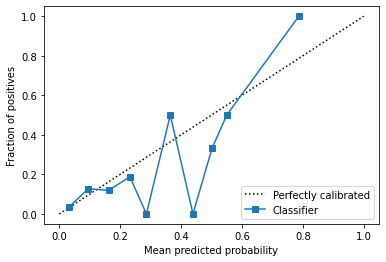

In [91]:
# откалибровать модель (в задаче требуются вероятности)
# здесь y_test, X_test сразу подставляются из последней итерации TimeSeriesSplit валидации
# судя по графику калибровка требуется
CalibrationDisplay.from_predictions(y_test, 
                                    model.predict_proba(X_test)[:,1],
                                    n_bins=15)

Learning rate set to 0.013115
0:	learn: 0.6819889	total: 30.5ms	remaining: 30.5s
600:	learn: 0.2088408	total: 17.2s	remaining: 11.4s
999:	learn: 0.1685105	total: 32.5s	remaining: 0us
Learning rate set to 0.013115
0:	learn: 0.6822325	total: 24.1ms	remaining: 24.1s
600:	learn: 0.2164205	total: 17.6s	remaining: 11.7s
999:	learn: 0.1764330	total: 30.1s	remaining: 0us
Learning rate set to 0.013115
0:	learn: 0.6817476	total: 20.7ms	remaining: 20.7s
600:	learn: 0.2352663	total: 16.7s	remaining: 11.1s
999:	learn: 0.1893784	total: 28.7s	remaining: 0us


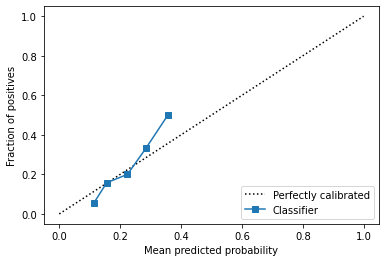

In [92]:
# калибруем
calibration = CalibratedClassifierCV(model, cv=3, method='sigmoid')
calibration.fit(X_train, y_train)
CalibrationDisplay.from_predictions(y_test, 
                                    calibration.predict_proba(X_test)[:,1],
                                    n_bins=15)

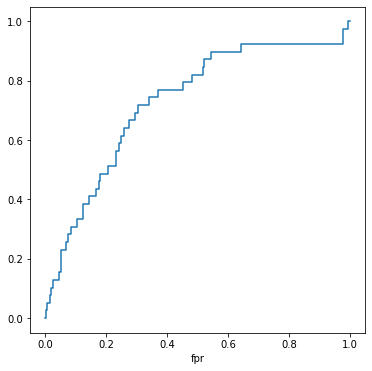

In [93]:
# построим график roc
fprs, tprs, thrs = roc_curve(y_test,calibration.predict_proba(X_test)[:,1])
roc = pd.DataFrame({'fpr':fprs,'tpr':tprs,'thr':thrs})
roc.set_index('fpr')['tpr'].plot(figsize=(6,6))

In [94]:
score = roc_auc_score(y_test,calibration.predict_proba(X_test)[:,1])
print(f'Calibrated model roc_auc_score is: {score}')

Calibrated model roc_auc_score is: 0.7271773897540768


In [95]:
# посмотрим на важность фичей в бейслайне
model_meta = calibration.base_estimator.steps[0][1]
fe = pd.DataFrame()
fe['column'] = np.array(X_test.columns)
fe['importance'] = np.array(model_meta.feature_importances_)
fe.sort_values(by='importance', ascending=False)

,column,importance
17,deals_period,13.977880
10,Age,11.066664
4,Tavern,8.943634
15,First_deal_date_month,7.420156
6,Hashed_deal_detail_3,6.951647
3,Region,6.478566
11,Deal_date_dayofweek,6.456202
14,Deal_date_month,5.880473
12,First_deal_date_dayofweek,5.360011
7,Hashed_deal_detail_4,4.521924


In [96]:
# избавимся от Deal_date определённые значения которого аномально доминирую в тестовом датасете
# Secret_dwarf_info тоже уберем, в основном пустые
# в надежде на то что система проверки примеит лучше новую модель
use_features_cut_2 = [
    col for col in use_features 
    if col not in ('Secret_dwarf_info_1', 'Secret_dwarf_info_2', 'Secret_dwarf_info_3', 'Deal_date_month', 'Deal_date_dayofweek')
]

cat_features_cut_2 = [
    col for col in cat_features 
    if col not in ('Secret_dwarf_info_1', 'Secret_dwarf_info_2', 'Secret_dwarf_info_3', 'Deal_date_month', 'Deal_date_dayofweek')
]

X = df[use_features_cut_2]
y = df['Default']
X_train, y_train, X_test, y_test, avg_score, model = learn_catboost(X, y, cat_features_cut_2)

Learning rate set to 0.007843
0:	learn: 0.6890780	total: 4.31ms	remaining: 4.3s
600:	learn: 0.3030286	total: 13.7s	remaining: 9.1s
999:	learn: 0.2337590	total: 24.2s	remaining: 0us
[0.7193118228360519]
Learning rate set to 0.010545
0:	learn: 0.6856819	total: 17.8ms	remaining: 17.8s
600:	learn: 0.2974252	total: 14.2s	remaining: 9.41s
999:	learn: 0.2439720	total: 24.3s	remaining: 0us
[0.7193118228360519, 0.6616087388282026]
Learning rate set to 0.012538
0:	learn: 0.6837744	total: 18ms	remaining: 18s
600:	learn: 0.2745703	total: 15.1s	remaining: 10.1s
999:	learn: 0.2323134	total: 26.5s	remaining: 0us
[0.7193118228360519, 0.6616087388282026, 0.7428912783751493]
Learning rate set to 0.014177
0:	learn: 0.6822984	total: 20.4ms	remaining: 20.3s
600:	learn: 0.2654419	total: 14.9s	remaining: 9.9s
999:	learn: 0.2237317	total: 25.2s	remaining: 0us
[0.7193118228360519, 0.6616087388282026, 0.7428912783751493, 0.7330519153225806]
Learning rate set to 0.015594
0:	learn: 0.6803095	total: 11.7ms	remaini

In [99]:
print(f'CV avg roc_auc_score cut_2 is: {avg_score}')

CV avg roc_auc_score cut_2 is: 0.7246


Learning rate set to 0.013115
0:	learn: 0.6830018	total: 22.9ms	remaining: 22.9s
600:	learn: 0.2235474	total: 16.6s	remaining: 11s
999:	learn: 0.1802649	total: 28.3s	remaining: 0us
Learning rate set to 0.013115
0:	learn: 0.6829821	total: 23.3ms	remaining: 23.3s
600:	learn: 0.2444653	total: 16.3s	remaining: 10.8s
999:	learn: 0.2026274	total: 27.8s	remaining: 0us
Learning rate set to 0.013115
0:	learn: 0.6829722	total: 29.2ms	remaining: 29.2s
600:	learn: 0.2441776	total: 17.2s	remaining: 11.4s
999:	learn: 0.2004780	total: 30.1s	remaining: 0us


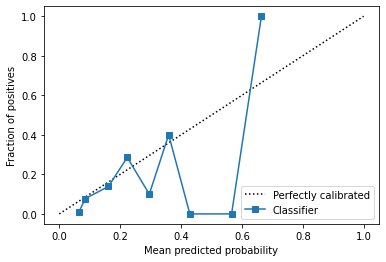

In [100]:
calibration = CalibratedClassifierCV(model, cv=3, method='sigmoid')
calibration.fit(X_train, y_train)
CalibrationDisplay.from_predictions(y_test, 
                                    calibration.predict_proba(X_test)[:,1],
                                    n_bins=15)

In [130]:
# другую модель обучим
use_features = start_categories_original + \
               start_numeric_features + \
               new_date_categories_original + \
               new_features + \
               new_categories #+ new_add_categories_original

# попробовать оставить эти фичи?
use_features = [
    col for col in use_features 
    if 'Secret_dwarf_info' not in col
]

X = df[use_features]
y = df['Default']

# здесь мы уже нмиже провели кросс-валидацию и вернулись сюда с луычшими гиперпараметрами
rf_params = {'classifier__n_estimators': 50,
             'classifier__max_depth': 5,
             'classifier__min_samples_split': 10,
             'classifier__min_samples_leaf': 1}

X_train, \
y_train, \
X_test, \
y_test, \
avg_score, \
model, \
start_categories_encoder, \
new_date_categories_encoder, \
use_features = learn_rf(X, y, 30, rf_params)

[0.7329741635909037, 0.6414697120158889, 0.7263696876600101, 0.7634198588709679, 0.718315767395522]


In [126]:
# Как показала проверка на отдельном тестовом датасете - то что на кросс валдидации трейна качество хуже ещё ничего не значит
print(f'CV avg roc_auc_score cut_2 is: {avg_score}')

CV avg roc_auc_score cut_2 is: 0.7165


In [186]:
# колхозим кросс валидацию
use_features_2 = start_categories_original + \
                 start_numeric_features + \
                 new_date_categories_original + \
                 new_features + \
                 new_categories #+ new_add_categories_original

# попробовать оставить эти фичи?
use_features_2 = [
    col for col in use_features_2 
    if 'Secret_dwarf_info' not in col
]

X = df[use_features_2]
y = df['Default']

param_grid = {
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 5, 10],
    # 'classification__max_features': ['auto', 'sqrt', 'log2'],
    # 'classification__criterion': ['gini', 'entropy'],
    # 'classification__bootstrap': [True, False]
}

values = list(param_grid.values())
combinations = list(itertools.product(*values))

param_combinations = [
    dict(zip(param_grid.keys(), combination)) 
    for combination in combinations
]

scores = []
for combination in param_combinations:
    # print(combination)
    X_train_2, \
    y_train_2, \
    X_test_2, \
    y_test_2, \
    avg_score_2, \
    model_2, \
    start_categories_encoder_2, \
    new_date_categories_encoder_2, \
    use_features_2 = learn_rf(X, y, 30, combination)
    scores.append(avg_score_2)

C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.686301940707227, 0.5805759682224428, 0.6480969448711383, 0.6643145161290324, 0.553982486497824]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7238659364210025, 0.6314200595829196, 0.699453831711896, 0.6773248487903226, 0.6891091185569713]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7384807715204191, 0.6018272095332671, 0.6989759344598053, 0.7217111895161291, 0.6859105448062504]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.6710620311941897, 0.6035749751737834, 0.6681344939409455, 0.6505166330645161, 0.6338943946305909]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7238659364210025, 0.6314200595829196, 0.699453831711896, 0.6773248487903226, 0.6891091185569713]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7384807715204191, 0.6018272095332671, 0.6989759344598053, 0.7217111895161291, 0.6859105448062504]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7239254673175378, 0.6103078450844092, 0.6688513398190817, 0.7174899193548387, 0.6508311048188349]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7238659364210025, 0.6314200595829196, 0.699453831711896, 0.6773248487903226, 0.6891091185569713]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7384807715204191, 0.6018272095332671, 0.6989759344598053, 0.7217111895161291, 0.6859105448062504]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7369032027622336, 0.6347964250248261, 0.7134835296125619, 0.6887915826612903, 0.6958208798699597]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.725532801523991, 0.6442105263157895, 0.7164874551971326, 0.7138671875, 0.6955324838760422]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7340754851768068, 0.6197815292949355, 0.7362348523638846, 0.7502205141129032, 0.6221488123328613]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7170645314918442, 0.6211519364448858, 0.7214883085850827, 0.7093939012096775, 0.7075140265324315]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.725532801523991, 0.6442105263157895, 0.7164874551971326, 0.7138671875, 0.6955324838760422]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7340754851768068, 0.6197815292949355, 0.7362348523638846, 0.7502205141129032, 0.6221488123328613]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7312328848672462, 0.6304667328699107, 0.7095579450418159, 0.7237273185483871, 0.6996748990614021]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.725532801523991, 0.6442105263157895, 0.7164874551971326, 0.7138671875, 0.6955324838760422]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7340754851768068, 0.6197815292949355, 0.7362348523638846, 0.7502205141129032, 0.6221488123328613]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7043398023574234, 0.5851042701092353, 0.6765488991295443, 0.7057081653225807, 0.6558387079859471]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7222139540421479, 0.615650446871897, 0.6873015873015873, 0.7188445060483871, 0.6794609616695506]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7428711751398976, 0.6091559086395234, 0.7062297320361837, 0.7465347782258064, 0.6863038120706833]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.6969877366353139, 0.6314597815292948, 0.6564772145417306, 0.7101499495967741, 0.6703371611347071]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7222139540421479, 0.615650446871897, 0.6873015873015873, 0.7188445060483871, 0.6794609616695506]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7428711751398976, 0.6091559086395234, 0.7062297320361837, 0.7465347782258064, 0.6863038120706833]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.6829979759495178, 0.6305263157894736, 0.6647038743812937, 0.680727066532258, 0.6627864296575953]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7222139540421479, 0.615650446871897, 0.6873015873015873, 0.7188445060483871, 0.6794609616695506]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7428711751398976, 0.6091559086395234, 0.7062297320361837, 0.7465347782258064, 0.6863038120706833]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7144600547684248, 0.6545382323733863, 0.6821812596006145, 0.6838142641129032, 0.6277332074878088]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7370520300035719, 0.6466335650446872, 0.7075780849974398, 0.7369581653225806, 0.71606103507944]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7330634599357067, 0.6361469712015888, 0.720873869260966, 0.7427545362903226, 0.7048922447695454]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7186867484224313, 0.6488579940417081, 0.6938044034818228, 0.6867439516129032, 0.659640291542132]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7370520300035719, 0.6466335650446872, 0.7075780849974398, 0.7369581653225806, 0.71606103507944]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7330634599357067, 0.6361469712015888, 0.720873869260966, 0.7427545362903226, 0.7048922447695454]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7307417549708298, 0.6258192651439921, 0.6814132104454684, 0.7384072580645161, 0.6787530805935714]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7370520300035719, 0.6466335650446872, 0.7075780849974398, 0.7369581653225806, 0.71606103507944]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7330634599357067, 0.6361469712015888, 0.720873869260966, 0.7427545362903226, 0.7048922447695454]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7318728420050007, 0.6577954319761669, 0.7220856801501963, 0.7442666330645161, 0.7046300665932568]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7308459340397667, 0.6478053624627607, 0.722563577402287, 0.7526461693548387, 0.7075402443500602]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7364567210382188, 0.6488579940417081, 0.7323434033111452, 0.7517011088709677, 0.709270620313565]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7220502440766757, 0.6562859980139027, 0.727120669056153, 0.7602066532258064, 0.7125478475171726]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7308459340397667, 0.6478053624627607, 0.722563577402287, 0.7526461693548387, 0.7075402443500602]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7364567210382188, 0.6488579940417081, 0.7323434033111452, 0.7517011088709677, 0.709270620313565]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7329741635909037, 0.6414697120158889, 0.7263696876600101, 0.7634198588709679, 0.718315767395522]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7308459340397667, 0.6478053624627607, 0.722563577402287, 0.7526461693548387, 0.7075402443500602]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7364567210382188, 0.6488579940417081, 0.7323434033111452, 0.7517011088709677, 0.709270620313565]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7158292653887367, 0.6175173783515393, 0.7039085168117425, 0.7341229838709676, 0.6898956530858372]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7274973211096559, 0.63519364448858, 0.7164021164021164, 0.7344380040322581, 0.690105395626868]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7364567210382189, 0.6323733862959284, 0.7226830517153099, 0.7501260080645161, 0.70478737349903]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7280330991784736, 0.6348361469712015, 0.7006997781191329, 0.6989667338709679, 0.6795133973048083]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7274973211096559, 0.63519364448858, 0.7164021164021164, 0.7344380040322581, 0.690105395626868]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7364567210382189, 0.6323733862959284, 0.7226830517153099, 0.7501260080645161, 0.70478737349903]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7274675556613882, 0.6384905660377358, 0.6934971838197644, 0.7409904233870968, 0.6893188610980022]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7274973211096559, 0.63519364448858, 0.7164021164021164, 0.7344380040322581, 0.690105395626868]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7364567210382189, 0.6323733862959284, 0.7226830517153099, 0.7501260080645161, 0.70478737349903]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7074205262531255, 0.6568619662363456, 0.6721454173067076, 0.6885710685483871, 0.6502018771957423]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7304441004881534, 0.6454816285998013, 0.7055640894350572, 0.731413810483871, 0.6999632950553196]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7326467436599595, 0.6499304865938431, 0.7189281447345963, 0.7591355846774193, 0.7063604425567616]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7078372425288725, 0.6296921549155908, 0.6800477897252091, 0.6929813508064516, 0.6669550626605842]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7304441004881534, 0.6454816285998013, 0.7055640894350572, 0.731413810483871, 0.6999632950553196]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7326467436599595, 0.6499304865938431, 0.7189281447345963, 0.7591355846774193, 0.7063604425567616]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7290153589713061, 0.6230585898709037, 0.6937019969278032, 0.725680443548387, 0.6834460699491374]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7304441004881534, 0.6454816285998013, 0.7055640894350572, 0.731413810483871, 0.6999632950553196]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7326467436599595, 0.6499304865938431, 0.7189281447345963, 0.7591355846774193, 0.7063604425567616]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7210977497321108, 0.649811320754717, 0.7146612049837856, 0.7414944556451613, 0.7001730375963504]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7252649124895821, 0.6469910625620655, 0.7207373271889401, 0.7482358870967741, 0.707618897802947]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7319323729015359, 0.6496921549155907, 0.7298856460146783, 0.7534022177419355, 0.7035289182528446]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7180616740088106, 0.6436146971201588, 0.7233657620754395, 0.7482988911290323, 0.7054690367573803]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7252649124895821, 0.6469910625620655, 0.7207373271889401, 0.7482358870967741, 0.707618897802947]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7319323729015359, 0.6496921549155907, 0.7298856460146783, 0.7534022177419355, 0.7035289182528446]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7241933563519466, 0.6371797418073485, 0.7260283324799454, 0.7505040322580645, 0.7047873734990299]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7252649124895821, 0.6469910625620655, 0.7207373271889401, 0.7482358870967741, 0.707618897802947]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7319323729015359, 0.6496921549155907, 0.7298856460146783, 0.7534022177419355, 0.7035289182528446]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7173770686986546, 0.6179940417080437, 0.6868748933265062, 0.7190020161290323, 0.6896334749095485]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7269615430408383, 0.6395233366434955, 0.7162997098480969, 0.7494959677419355, 0.6912065439672802]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7346112632456243, 0.6448857994041708, 0.7272913466461853, 0.7586315524193549, 0.7053641654868649]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.729283248005715, 0.6369414101290963, 0.6968424645844, 0.7160408266129032, 0.6793036547637774]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7269615430408383, 0.6395233366434955, 0.7162997098480969, 0.7494959677419355, 0.6912065439672802]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7346112632456243, 0.6448857994041708, 0.7272913466461853, 0.7586315524193549, 0.7053641654868649]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7332718180735802, 0.6265342601787488, 0.7009045912271719, 0.7504410282258065, 0.6862775942530545]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7269615430408383, 0.6395233366434955, 0.7162997098480969, 0.7494959677419355, 0.6912065439672802]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7346112632456243, 0.6448857994041708, 0.7272913466461853, 0.7586315524193549, 0.7053641654868649]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.717421716871056, 0.6493346573982125, 0.6846390168970814, 0.6898311491935485, 0.65232552042368]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7285688772472914, 0.6419463753723933, 0.7122546509643284, 0.7427545362903225, 0.6960830580462483]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7342540778664126, 0.645441906653426, 0.7275644307902372, 0.7584425403225806, 0.7069372345445966]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7194606500773901, 0.6272889771598809, 0.6935654548557775, 0.6871849798387096, 0.6817156939856326]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7285688772472914, 0.6419463753723933, 0.7122546509643284, 0.7427545362903225, 0.6960830580462483]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7342540778664126, 0.645441906653426, 0.7275644307902372, 0.7584425403225806, 0.7069372345445966]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7246398380759613, 0.6324925521350546, 0.6952551629970984, 0.7174899193548386, 0.6877457920402705]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7285688772472914, 0.6419463753723933, 0.7122546509643284, 0.7427545362903225, 0.6960830580462483]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7342540778664126, 0.645441906653426, 0.7275644307902372, 0.7584425403225806, 0.7069372345445966]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7221395404214789, 0.6484210526315789, 0.7204301075268817, 0.7362021169354838, 0.7005925226784122]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7292237171091798, 0.6474280039721946, 0.7231950844854069, 0.7465977822580645, 0.7019034135598553]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7266638885581617, 0.650446871896723, 0.7280081925243215, 0.7484879032258065, 0.7052068585810917]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7198773663531374, 0.6464746772591857, 0.7252090800477897, 0.7432585685483871, 0.708720046143359]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7292237171091798, 0.6474280039721946, 0.7231950844854069, 0.7465977822580645, 0.7019034135598553]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7266638885581617, 0.650446871896723, 0.7280081925243215, 0.7484879032258065, 0.7052068585810917]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7202345517323491, 0.6434558093346574, 0.7251749445297833, 0.7403603830645162, 0.7013266215720203]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7292237171091798, 0.6474280039721946, 0.7231950844854069, 0.7465977822580645, 0.7019034135598553]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7266638885581617, 0.650446871896723, 0.7280081925243215, 0.7484879032258065, 0.7052068585810917]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7226157875937611, 0.6213306852035749, 0.6907663423792456, 0.7210181451612903, 0.6926223061192386]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7282712227646149, 0.6384905660377358, 0.7200887523468168, 0.7474798387096775, 0.7014314928425358]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7356232884867246, 0.642025819265144, 0.7331967912613073, 0.7535282258064516, 0.7073042839914006]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7232408620073818, 0.6346772591857001, 0.7079023724185015, 0.7215221774193548, 0.693880761365424]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7282712227646149, 0.6384905660377358, 0.7200887523468168, 0.7474798387096775, 0.7014314928425358]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7356232884867246, 0.642025819265144, 0.7331967912613073, 0.7535282258064516, 0.7073042839914006]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7305929277294916, 0.633167825223436, 0.6989247311827956, 0.7389742943548387, 0.6949294740705784]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7282712227646149, 0.6384905660377358, 0.7200887523468168, 0.7474798387096775, 0.7014314928425358]


C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
C:\Users\maslo\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: U

[0.7356232884867246, 0.642025819265144, 0.7331967912613073, 0.7535282258064516, 0.7073042839914006]


In [ ]:
# берем argmax массива scores и по этому индексу вынимаем параметры из param_combinations

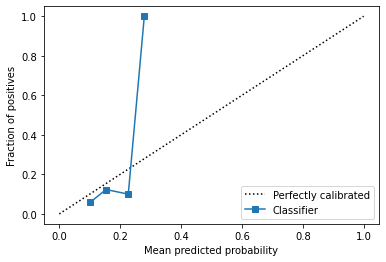

In [133]:
calibration = CalibratedClassifierCV(model, cv=3, method='sigmoid')
calibration.fit(X_train[use_features], y_train)
CalibrationDisplay.from_predictions(y_test, 
                                    calibration.predict_proba(X_test[use_features])[:,1],
                                    n_bins=15)

# Применение модели

In [134]:
test = pd.read_csv("C:/Users/maslo/курсы/karpov_start_ml/5_module/6_lesson/materials/test.csv")

In [135]:
# всё что нужно сделать с датасетом чтобы применить модель
test['Successful_deals_count'] = test['Successful_deals_count'].fillna(0)
test['Region'] = test['Region'].fillna('Tavern_district_3')
test['Secret_dwarf_info_1'] = test['Secret_dwarf_info_1'].fillna('unknown').astype(str)
test['Secret_dwarf_info_2'] = test['Secret_dwarf_info_2'].fillna('unknown').astype(str)
test['Secret_dwarf_info_3'] = test['Secret_dwarf_info_3'].fillna('unknown').astype(str)
test['Deal_date'] = pd.to_datetime(test['Deal_date'], format='%Y-%m-%d')
test['First_deal_date'] = pd.to_datetime(test['First_deal_date'], format='%Y-%m-%d')
test['First_default_date'] = pd.to_datetime(test['First_default_date'], format='%Y-%m-%d')

In [136]:
# энкодер обычных категорий
start_categories_original = [
    'Region',
    'Tavern',
    'Hashed_deal_detail_2',
    'Hashed_deal_detail_3',
    'Hashed_deal_detail_4',
    'Gender'
]
test = apply_category_encoder(test, start_categories_original, start_categories_encoder)

In [137]:
test['Deal_date_dayofweek'] = test['Deal_date'].dt.dayofweek
test['First_deal_date_dayofweek'] = test['First_deal_date'].dt.dayofweek
test['First_default_date_dayofweek'] = test['First_default_date'].dt.dayofweek
test['Deal_date_month'] = test['Deal_date'].dt.month
test['First_deal_date_month'] = test['First_deal_date'].dt.month
test['First_default_date_month'] = test['First_default_date'].dt.month

new_date_categories_original = [
    'Deal_date_dayofweek', 
    'First_deal_date_dayofweek', 
    'First_default_date_dayofweek', 
    'Deal_date_month', 
    'First_deal_date_month', 
    'First_default_date_month'
]
# энкодер категорий для дат
test = apply_category_encoder(
    test, 
    new_date_categories_original,
    new_date_categories_encoder
)

# остальные фичи
test['deals_period'] = (test['Deal_date'] - test['First_deal_date']).dt.days
test['first_default_period'] = (test['Deal_date'] - test['First_default_date']).dt.days
test['first_default_period'] = test['first_default_period'].fillna(0)
test['first_default_period_group'] = np.ceil(test['first_default_period'] / 30)
test['was_defaulted'] = (~test['first_default_period'].isna()).astype(int)

# test = apply_category_encoder(test, ['first_default_period_group',], new_add_categories_encoder)

In [138]:
test['Prediction'] = calibration.predict_proba(test[use_features])[:,1]

In [200]:
#формируем сабмит
test[['Deal_id', 'Prediction']].to_csv('C:/Users/maslo/курсы/karpov_start_ml/5_module/6_lesson/out.csv', index=False)

# Анализ тестовых данных

In [128]:
# забегая вперед можно сказать что точность на тестовых данных не устроила на бейслайне
# так что надо найти различия в раcпределении тестовых и трейне, что-то сделать по этому поводу

In [129]:
len(df) / len(test)

3.2032355915065724

In [130]:
# скопом просто проверим и аномалии выведем
# значения которые есть в тесте но нет в трейне
# значения которых относительно общего объема больше в тесте чем в трейне
train_len = len(df)
test_len = len(test)

for feature in cat_features:
    # print(feature)
    test_stat = test.groupby(feature)['Deal_id'].count().reset_index().rename(columns={'Deal_id':'count'})
    test_stat[feature] = test_stat[feature].astype(str)
    train_stat = df.groupby(feature)['Deal_id'].count().reset_index().rename(columns={'Deal_id':'count'})
    train_stat[feature] = train_stat[feature].astype(str)
    stat_match = pd.merge(test_stat, train_stat, on=feature, how='left')
    stat_match['scale_test'] = stat_match['count_x'] / test_len
    stat_match['scale_train'] = stat_match['count_y'] / train_len
    stat_match['scale'] = stat_match['scale_test'] / stat_match['scale_train']
    out_nan = stat_match[stat_match['count_y'].isna()][[feature, 'count_x', 'count_y', 'scale']]
    out_anomaly = stat_match[stat_match['scale'] > 2][[feature, 'count_x', 'count_y', 'scale']]
    if len(out_nan) > 0:
        print(out_nan.to_string(index=False))
    if len(out_anomaly) > 0:
        print(out_anomaly.to_string(index=False))

Secret_dwarf_info_1  count_x  count_y    scale
                7.5        3        4 2.402427
Secret_dwarf_info_2  count_x  count_y    scale
                1.0        2        1 6.406471
                2.0        1        1 3.203236
Tavern  count_x  count_y  scale
    61        3      NaN    NaN
    77        2      NaN    NaN
    79        7      NaN    NaN
    81        2      NaN    NaN
Tavern  count_x  count_y    scale
    39       68    108.0 2.016852
    43        6      6.0 3.203236
    44        1      1.0 3.203236
    45       11     11.0 3.203236
    47        3      1.0 9.609707
    58        1      1.0 3.203236
Hashed_deal_detail_2  count_x  count_y  scale
                  17        2      NaN    NaN
                  18        1      NaN    NaN
                  25        1      NaN    NaN
                  28        1      NaN    NaN
                  33        1      NaN    NaN
Hashed_deal_detail_2  count_x  count_y    scale
                  12        3      1.0 9.60

In [ ]:
# Здесь интересно доминирование значения 10 для атрибута Deal_date_month в тестовом датасете

In [146]:
# проверим значения которые есть в трейне но нет в тесте
train_len = len(df)
test_len = len(test)

for feature in cat_features:
    # print(feature)
    test_stat = test.groupby(feature)['Deal_id'].count().reset_index().rename(columns={'Deal_id':'count'})
    test_stat[feature] = test_stat[feature].astype(str)
    train_stat = df.groupby(feature)['Deal_id'].count().reset_index().rename(columns={'Deal_id':'count'})
    train_stat[feature] = train_stat[feature].astype(str)
    stat_match = pd.merge(train_stat, test_stat, on=feature, how='left')
    out_nan = stat_match[stat_match['count_y'].isna()]
    if len(out_nan) > 0:
        print(out_nan.to_string(index=False))

Secret_dwarf_info_1  count_x  count_y
                2.5        4      NaN
                9.5        1      NaN
Secret_dwarf_info_3  count_x  count_y
                8.0        1      NaN
Tavern  count_x  count_y
    10        2      NaN
     2        5      NaN
    22        5      NaN
    23      192      NaN
Hashed_deal_detail_2  count_x  count_y
                  13        2      NaN
                  19        1      NaN
                  20        1      NaN
                  21        1      NaN
                  78        1      NaN
Hashed_deal_detail_3  count_x  count_y
                  29        2      NaN
Hashed_deal_detail_4  count_x  count_y
                16.5        1      NaN
                32.5        1      NaN
                37.5        1      NaN
First_default_date_dayofweek  count_x  count_y
                         2.0        1      NaN
                         3.0        2      NaN
Deal_date_month  count_x  count_y
              2      182      NaN
        